### <center>   Travail pratique 4 : Physique Numérique - PHY-3500

## <center> Équations différentielles partielles

#### <center>Par Julien Houle, Olivier Lapointe-Gagné et Pierre-Luc Larouche

***

Voici les différents modules, librairies et variables utilisées au travers du travail :

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from math import e
import time
from scipy.constants import hbar
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.animation as animation
from IPython.display import HTML
Writer = animation.FFMpegWriter(fps=20, metadata=dict(artist='Me'), bitrate=1800)

In [14]:
m_e = 9.109e-31 #Masse de l'électron, en kg
a_1 = 0 #Composante de matrice qui sera définie plus tard
a_2 = 0 #Composante de matrice qui sera définie plus tard

***

### Question 1

On peut d'abord implémenter la fonction d'onde de l'électron dans la boîte unidimensionnelle à $t=0$, puis l'utiliser pour produire un vecteur dont chaque composante corespond à la valeur de $\psi$ au départ à chaque incrément de position $a$, qui correspond ici à un millième du puit. Une troisième fonction construira alors les matrices tridiagonales $A$ ou $B$ d'un seul coup et une quatrième fonction en calculera le vecteur $v$ à partir de la matrice $B$ et du vecteur $\psi$.

In [15]:
def psi_0(x, L):
    '''
    Fonction qui calcule la fonction d'onde d'un électron au temps 0 à une position donné

    Paramètres: x: La position de l'électron, L: La longueur de la boîte

    Retourne: La valeur de psi 
    '''
    x_0 = L/2
    sig = 1e-10 #en mètres
    k = 5e10 # en 1/mètres
    psi = np.exp(-(x-x_0)**2/(2*sig**2))*np.exp(1j*k*x)
    return psi

In [16]:
def psi_0_vec(L,N):
    '''
    Fonction qui construit le vecteur psi(0) en fonction des pas de distance a

    Paramètres : L, la longueur de la boîte unidimensionnelle, N, le nombre de pas dans la boîte

    Retourne : le vecteur psi(0)
    '''
    a = L/N
    psi0 = np.empty([N+1,1],complex)
    for i in range(N+1):
        psi0[i]=psi_0(i*a,L)
    return psi0

In [17]:
def matrice(lettre,N,L,h):
    '''
    Fonction qui crée la matrice A ou B

    Paramètres: lettre: choix de matrice à créer, 
                N:nombre d'itérations positionnelles, L: longueur de la boîte, h:grandeur des itérations temporelles

    Retourne: une matrice tridiagonale qui constitue notre système d'équations différentielles
    '''
    global a_1
    global a_2
    a = L/N
    a_1 = 1 + h*1j*hbar/(2*m_e*a**2)
    a_2 = -h*1j*hbar/(4*m_e*a**2)
    b_1 = 1 - h*1j*hbar/(2*m_e*a**2)
    b_2 = h*1j*hbar/(4*m_e*a**2)
    matrice = np.zeros((N+1,N+1),complex)
    if lettre == 'A':
        for i in range(N+1):
            for l in range(N+1):
                if i == l:
                    matrice[i][l]  = a_1
                if i == l + 1 or i == l -1:
                    matrice[i][l] = a_2
    if lettre == 'B':
        for i in range(N+1):
            for l in range(N+1):
                if i == l:
                    matrice[i][l]  = b_1
                if i == l + 1 or i == l -1:
                    matrice[i][l] = b_2
    return matrice

In [18]:
def v_vec(L,N,h,psi):
    '''
    Fonction qui construit le vecteur v à partir de B et psi

    Paramètres: L:Longueur de la boîte, N: nombre de pas positionnel, h:grandeur des pas temporelles

    Retourne: le vecteur v recherché
    '''
    a = L/N
    b_1 = 1 - h*1j*hbar/(2*m_e*a**2)
    b_2 = h*1j*hbar/(4*m_e*a**2)
    v = np.empty((N+1,1),complex)
    v[0] = b_1*psi[0]+b_2*psi[1]
    v[N] = b_1*psi[N]+b_2*psi[N-1]
    for i in range(1,N):
        v[i] = b_1*psi[i]+b_2*(psi[i-1]+psi[i+1])
    return v

### Question 2

Une cinquième fonction, implémentant un algorithme dérivé de celui de Thomas, permettra d'extraire le vecteur $x$, la valeur de la fonction d'onde pour chaque incrément de position au temps $h$ voulu, à partir de la matrice $A$ et du vecteur $v$.

In [19]:
def Thomas(N, VecteurIni):
    '''
    Fonction qui utilise l'algorithme de Thomas pour résoudre AX = v. Résout spécifiquement avec la matrice A.

    Paramètres: "N" est la dimension de A et de V, "Vecteur" est une matrice vecteur

    Retourne: Un vecteur correspondant à X

    NOTE: Jesus saith unto him, Thomas, because thou hast seen me, thou hast believed:
    blessed are they that have not seen, and yet have believed
    '''
    Vecteur = np.copy(VecteurIni)
    matriceloc = [a_2/a_1]
    Vecteur[0][0] /= a_1

    # Boucle calculant la diagonale suppérieure de la matrice A, qui sert à calculer les X
    for i in range(N):
        div = (a_1 - a_2 * matriceloc[i-1])
        matriceloc.append(a_2/div)
        Vecteur[i+1][0] = (Vecteur[i+1][0] - a_2 * Vecteur[i][0]) / div

    # Boucle calculant les X
    for i in reversed(range(N)):
        Vecteur[i][0] -= matriceloc[i] * (Vecteur[i + 1][0])
    return Vecteur

### Question 3

On peut alors regrouper toutes ces fonctions dans une seule afin de calculer $\psi$ pour chaque $x$ à chaque incrément de temps $h$ selon la méthode de Crank-Nicolson et en ensuite en produire une animation.

In [20]:
def Crank_Nico(h,N,L,m):
    '''
    Fonction qui estime la valeur de psi en fonction du temps et de x avec la méthode de Crank-Nicolson

    Paramètres: h: grandeur des itérations temporelles, N: nombre d'itérations positionnelle, L:longueur de la boîte,
                m: nombre d'itérations temporelles

    Retourne: liste des états
    '''
    
    #On crée nos matrices
    A = matrice("A",N,1e-8,1e-18)
    
    #On crée notre vecteur initial
    psi = psi_0_vec(L,N)

    #On crée nos liste vides qui serviront à stocker nos points (eventuellement pour tracer)
    liste_x = [0]
    for i in range(N):
        liste_x.append(liste_x[-1]+(L/N))
    liste_psi = []
    liste_etats = []

    #On crée un compteur pour le temps
    t=0
    
    #On crée le premier état (t=0)
    etat_1=np.transpose(psi)[0]
    liste_psi = etat_1
    liste_etats.append(liste_psi)

    #On crée une boucle infini
    while t<m*1e-18:
        #On augmente notre compteur de temps de h
        t += h
        #On applique la méhode de thomas pour trouver le deuxième etat
        v= v_vec(L,N,h,psi)
        psi = Thomas(N,v)

        etat = np.transpose(psi)[0]
        liste_psi = etat

        liste_etats.append(liste_psi)
    return liste_etats

<Figure size 432x288 with 0 Axes>

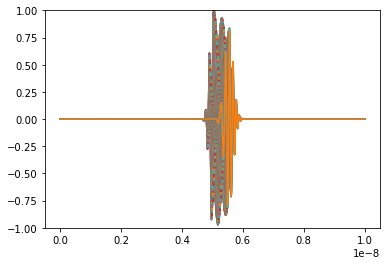

In [13]:
'''
Programmons l'animation la fonction d'onde qui se ne se traduit pas en fonction
'''

liste_y = Crank_Nico(1e-18,1000,1e-8,1000)
liste_x = [0]
for i in range(1000):
    liste_x.append(liste_x[-1]+((1e-8)/1000))

fig = plt.figure()


def animate(i):
    x = liste_x
    y = np.real(liste_y[i]) 
    fig.clear() 
    plt.plot(x,y)
    plt.plot(x,y)
    plt.ylim(-1,1)

ani = animation.FuncAnimation(fig, animate, interval=1,blit=False)
plt.show()
HTML(ani.to_jshtml())

In [35]:
Crank_Nico(1e-18,1000,1e-8,100)

[array([ 0.+0.j,  0.+0.j,  0.+0.j, ..., -0.+0.j, -0.+0.j,  0.-0.j]),
 array([ 8.19786013e-279+1.60877842e-278j,
         7.19798440e-278+3.85153894e-279j,
         1.49069093e-277-2.57078778e-277j, ...,
         6.38126821e-270+5.23314006e-270j,
        -4.26772683e-271+1.95576495e-270j,
        -4.77544835e-271+1.52911463e-271j]),
 array([ 8.44421770e-276+6.03355255e-276j,
         3.76235023e-275-1.70514544e-275j,
         7.86251845e-276-1.69630213e-274j, ...,
         4.39306068e-267+1.97362566e-267j,
         5.87803697e-269+1.16993313e-267j,
        -2.46835191e-268+1.60202352e-268j]),
 array([ 2.97056766e-273+4.08046012e-274j,
         7.30937403e-273-9.38907863e-273j,
        -2.06737164e-272-4.41809825e-272j, ...,
         1.38813446e-264+2.18734382e-265j,
         1.06697232e-265+3.25714056e-265j,
        -5.74519861e-266+6.44584195e-266j]),
 array([ 5.45429379e-271-2.00037812e-271j,
         3.96939745e-271-2.26409362e-270j,
        -7.50934841e-270-5.64934766e-270j, ...,
  

### Question 4

Idem qu'à la question précédante, en remplaçant seulement le calcul d'algèbre linéaire exécuté par notre algorithme dérivé de celui de Thomas par celui déjà implémenté dans Numpy, soit linalg. Nous avons constaté le même résultat numérique pour les deux, seulement un grand gain en temps en utilisant notre propre méthode de calcul, tel que démontré par la fontion chronomètre.

In [21]:
def Crank_Nico_linalg(h,N,L,m):
    '''
    Fonction qui estime la valeur de psi en fonction du temps et de x avec la méthode de Crank-Nicolson mais en utilisant 
    les fonction de linalg pour les opérations matricielles

    Paramètres: h: grandeur des itérations temporelles, N: nombre d'itérations positionnelle, L:longueur de la boîte,
                m: nombre d'itérations temporelles

    Retourne: liste des états
    '''
    
    #On crée nos matrices
    A = matrice("A",N,1e-8,1e-18)
    B = matrice("B",N,1e-8,1e-18)
    #On crée notre vecteur initial
    psi = psi_0_vec(L,N)

    #On crée nos liste vides qui serviront à stocker nos points (eventuellement pour tracer)
    liste_x = [0]
    for i in range(N):
        liste_x.append(liste_x[-1]+(L/N))
    liste_psi = []
    liste_etats = []

    #On crée un compteur pour le temps
    t=0
    
    #On crée le premier état (t=0)
    etat_1=np.transpose(psi)[0]
    liste_psi = etat_1
    liste_etats.append(liste_psi)

    #On crée une boucle infini
    while t<m*1e-18:
        #On augmente notre compteur de temps de h
        t += h
        #On applique la méhode de thomas pour trouver le deuxième etat
        v= np.matmul(B,psi)
        psi = np.linalg.solve(A,v)

        etat = np.transpose(psi)[0]
        liste_psi = etat

        liste_etats.append(liste_psi)
    return liste_etats

In [31]:
def timer_Crank():
    debut = time.time()
    Crank_Nico(1e-18,1000,1e-8,100)
    fin = time.time()
    debut1 = time.time()
    Crank_Nico_linalg(1e-18, 1000, 1e-8, 100)
    fin1 = time.time()
    print('Notre algorithme de Thomas prend {:.3} secondes pour faire 100 incréments de temps.'.format(fin-debut))
    print('L\'algorithme np.linalg  prend {:.3} secondes pour faire 100 incréments de temps.'.format(fin1-debut1))
    print('Notre algorithme est donc environ {:.3} plus rapide qu\'en utilisant linalg.'.format((fin1-debut1)/(fin-debut)))

In [32]:
timer_Crank()

Notre algorithme de Thomas prend 1.01 secondes pour faire 100 incréments de temps.
L'algorithme np.linalg  prend 6.77 secondes pour faire 100 incréments de temps.
Notre algorithme est donc environ 6.72 plus rapide qu'en utilisant linalg.


In [34]:
Crank_Nico_linalg(1e-18,1000,1e-8,100)

[array([ 0.+0.j,  0.+0.j,  0.+0.j, ..., -0.+0.j, -0.+0.j,  0.-0.j]),
 array([ 8.03898204e-279+1.55258454e-278j,
         6.97205603e-278+3.27659334e-279j,
         1.42722938e-277-2.49860789e-277j, ...,
         6.38126822e-270+5.23314007e-270j,
        -4.26772684e-271+1.95576496e-270j,
        -4.77544836e-271+1.52911463e-271j]),
 array([ 8.22258831e-276+5.77466720e-276j,
         3.62896643e-275-1.68045819e-275j,
         6.27340173e-276-1.64284716e-274j, ...,
         4.39306069e-267+1.97362566e-267j,
         5.87803704e-269+1.16993313e-267j,
        -2.46835191e-268+1.60202352e-268j]),
 array([ 2.88018395e-273+3.66695229e-274j,
         6.98752257e-273-9.16103021e-273j,
        -2.04408265e-272-4.25807228e-272j, ...,
         1.38813447e-264+2.18734381e-265j,
         1.06697233e-265+3.25714057e-265j,
        -5.74519861e-266+6.44584196e-266j]),
 array([ 5.26112892e-271-1.99924821e-271j,
         3.58981114e-271-2.19775121e-270j,
        -7.33830687e-270-5.38784163e-270j, ...,
  

### Question 5

La fonction d'onde se déplace au fil du temps de sa position au temps $t=0$ jusqu'à l'extrémité droite de la boîte unidimensionnelle lors des premiers incréments de temps. Ce comportement est attendu puisque la fonction initiale implique une exponentielle complexe positive. En s'approchant de la paroi, la fonction d'onde oscille de plus en plus vigoureusement, symbole que sa densité de probablité est de plus en plus incertaine. On peut reconnaître ensuite une sorte de réflection dure de la fonction d'onde sur la paroi, qui retournera à sa position intiale avant de se déplacer vers la seconde paroi de la boîte. Comme les comportements de la fonction d'onde calculé par notre fonction implémentée et celle de numpy.linalg sont identiques, on peut en déduire que notre algorithme est un moyen efficace de rapidement résoudre numériquement l'équation de Schrodinger pour cette particule dans une boîte.